# MNIST dataset with PyTorch, with CP decomposition
### Author: Yiming Fang

Reference: https://github.com/pytorch/examples \
reference: https://github.com/jacobgil/pytorch-tensor-decompositions

This is an implementation of neural network compression using CP decomposition.  As the example shown below, with MNIST dataset, I am able to compress the convoluted layers to 1/3 of the original size at the cost of about 1.5% of lowered accuracy. This implementation builds a decomposed network first, and then trains it from scratch to minimize the loss function.  
#### A few things to note: 
1. The decomposed model is more sensitive to learning rate than the original model, so the learning rate should be kept very low for the network to learn. 
2. There is no significant difference between the training time of the original and decomposed model; this is quite strange and I will do more testing to find out why this is the case.

In [1]:
# imports

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.transforms as transforms
from torchvision import models

import tensorly as tl
import tensorly
from itertools import chain
from tensorly.decomposition import parafac, partial_tucker

import os
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# define the network. I am using LeNet, although the code below should work for 
# any arbitrarily defined network, not only this one particularly.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
# this function applies the CP decomposition algorithm (via tensorly) to a layer.
# it can be replaced by other decomposition methods (Tucker, TT, HT, etc.)

def cp_decomposition_conv_layer(layer, rank):
    """ Gets a conv layer and a target rank, 
        returns a nn.Sequential object with the decomposition """

    # Perform CP decomposition on the layer weight tensorly. 
    l, f, v, h = parafac(layer.weight.data, rank=rank)[1]
    
    pointwise_s_to_r_layer = torch.nn.Conv2d(
            in_channels=f.shape[0], 
            out_channels=f.shape[1], 
            kernel_size=1, 
            stride=1, 
            padding=0, 
            dilation=layer.dilation, 
            bias=False)

    depthwise_vertical_layer = torch.nn.Conv2d(
            in_channels=v.shape[1], 
            out_channels=v.shape[1], 
            kernel_size=(v.shape[0], 1),
            stride=1, padding=(layer.padding[0], 0), 
            dilation=layer.dilation,
            groups=v.shape[1], 
            bias=False)

    depthwise_horizontal_layer = torch.nn.Conv2d(
            in_channels=h.shape[1], 
            out_channels=h.shape[1], 
            kernel_size=(1, h.shape[0]), 
            stride=layer.stride,
            padding=(0, layer.padding[0]), 
            dilation=layer.dilation, 
            groups=h.shape[1], 
            bias=False)

    pointwise_r_to_t_layer = torch.nn.Conv2d(
            in_channels=l.shape[1], 
            out_channels=l.shape[0], 
            kernel_size=1, 
            stride=1,
            padding=0, 
            dilation=layer.dilation, 
            bias=True)
    
    pointwise_r_to_t_layer.bias.data = layer.bias.data
    depthwise_horizontal_layer.weight.data = torch.transpose(h, 1, 0).unsqueeze(1).unsqueeze(1)
    depthwise_vertical_layer.weight.data = torch.transpose(v, 1, 0).unsqueeze(1).unsqueeze(-1)
    pointwise_s_to_r_layer.weight.data = torch.transpose(f, 1, 0).unsqueeze(-1).unsqueeze(-1)
    pointwise_r_to_t_layer.weight.data = l.unsqueeze(-1).unsqueeze(-1)

    new_layers = [pointwise_s_to_r_layer, depthwise_vertical_layer, 
                  depthwise_horizontal_layer, pointwise_r_to_t_layer]
    
    return nn.Sequential(*new_layers)

In [26]:
# check GPU availability
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
rate = 0.05


# load data
print('==> Loading data..')
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=0)


# build model
def build(decomp=True):
    print('==> Building model..')
    tl.set_backend('pytorch')
    full_net = Net()
    full_net = full_net.to(device)
    torch.save(full_net, 'model')
    if decomp:
        decompose()
    net = torch.load("model").cuda()
    print('==> Done')
    return net
    

# training
def train(epoch, train_acc, model):
    print('\nEpoch: ', epoch)
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=rate, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    train_loss = 0
    correct = 0
    total = 0
    print('|', end='')
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 10 == 0:
            print('=', end='')
    print('|', 'Accuracy:', 100. * correct / total,'% ', correct, '/', total)
    train_acc.append(correct / total)

    
# testing
def test(test_acc, best_acc, model):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        print('|', end='')
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            if batch_idx % 10 == 0:
                print('=', end='')
    acc = 100. * correct / total
    print('|', 'Accuracy:', acc, '% ', correct, '/', total)
    test_acc.append(correct / total) 
    return max(acc, best_acc)

        
# decomposition
def decompose():
    model = torch.load("model").cuda()
    model.eval()
    model.cpu()
    layers = model._modules
    for i, key in enumerate(layers.keys()):
        if i >= len(layers.keys()) - 2:
            break
        if isinstance(layers[key], torch.nn.modules.conv.Conv2d):
            conv_layer = layers[key]
            rank = max(conv_layer.weight.data.numpy().shape) // 10
            layers[key] = cp_decomposition_conv_layer(conv_layer, rank)
        torch.save(model, 'model')
    return model

==> Loading data..


In [27]:
net = build()
print(net, '\n')

full_net = build(decomp=False)
print(full_net)

==> Building model..
==> Done
Net(
  (conv1): Sequential(
    (0): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(3, 3, kernel_size=(3, 1), stride=(1, 1), groups=3, bias=False)
    (2): Conv2d(3, 3, kernel_size=(1, 3), stride=(1, 1), groups=3, bias=False)
    (3): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(32, 6, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(6, 6, kernel_size=(3, 1), stride=(1, 1), groups=6, bias=False)
    (2): Conv2d(6, 6, kernel_size=(1, 3), stride=(1, 1), groups=6, bias=False)
    (3): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
) 

==> Building model..
==> Done
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64

In [28]:
# Run functions

def run_train(i, model):
    optimizer = optim.SGD(model.parameters(), lr=rate, momentum=0.9, weight_decay=5e-4)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    train_acc = []
    test_acc = []
    best_acc = 0
    for epoch in range(i):
        train(epoch, train_acc, model)
        best_acc = test(test_acc, best_acc, model)
        scheduler.step()
        print('Current learning rate: ', scheduler.get_lr()[0])
    print('Best training accuracy overall: ', best_acc)
    return train_acc, test_acc, best_acc

def run_test(model):  
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    test_acc = []
    best_acc = 0
    best_acc = test(test_acc, best_acc, model)
    print('Testing accuracy: ', best_acc)
    return test_acc, best_acc

In [29]:
%%time

# this cell runs training using the decomposed model

train_acc, test_acc, best_acc = run_train(50, net)


Epoch:  0
|===============================================| Accuracy: 83.20166666666667 %  49921 / 60000
|==========| Accuracy: 96.89 %  9689 / 10000
Current learning rate:  0.05

Epoch:  1
|===============================================| Accuracy: 93.52333333333333 %  56114 / 60000
|==========| Accuracy: 97.55 %  9755 / 10000
Current learning rate:  0.05

Epoch:  2
|===============================================| Accuracy: 94.85166666666667 %  56911 / 60000
|==========| Accuracy: 98.04 %  9804 / 10000
Current learning rate:  0.05

Epoch:  3
|===============================================| Accuracy: 95.69833333333334 %  57419 / 60000
|==========| Accuracy: 98.03 %  9803 / 10000
Current learning rate:  0.05

Epoch:  4
|===============================================| Accuracy: 96.02666666666667 %  57616 / 60000
|==========| Accuracy: 98.14 %  9814 / 10000
Current learning rate:  0.05

Epoch:  5
|===============================================| Accuracy: 96.27833333333334 %  57767 / 

|==========| Accuracy: 98.68 %  9868 / 10000
Current learning rate:  0.003125

Epoch:  46
|===============================================| Accuracy: 97.725 %  58635 / 60000
|==========| Accuracy: 98.73 %  9873 / 10000
Current learning rate:  0.003125

Epoch:  47
|===============================================| Accuracy: 97.69333333333333 %  58616 / 60000
|==========| Accuracy: 98.77 %  9877 / 10000
Current learning rate:  0.003125

Epoch:  48
|===============================================| Accuracy: 97.90166666666667 %  58741 / 60000
|==========| Accuracy: 98.68 %  9868 / 10000
Current learning rate:  0.003125

Epoch:  49
|===============================================| Accuracy: 97.84166666666667 %  58705 / 60000
|==========| Accuracy: 98.38 %  9838 / 10000
Current learning rate:  0.00078125
Best training accuracy overall:  98.82
Wall time: 10min 39s


In [30]:
%%time

# this cell runs training using the full model (by adjusting model definition manually)

train_acc_full, test_acc_full, best_acc_full = run_train(50, full_net)


Epoch:  0
|===============================================| Accuracy: 91.99166666666666 %  55195 / 60000
|==========| Accuracy: 98.38 %  9838 / 10000
Current learning rate:  0.05

Epoch:  1
|===============================================| Accuracy: 96.94666666666667 %  58168 / 60000
|==========| Accuracy: 98.66 %  9866 / 10000
Current learning rate:  0.05

Epoch:  2
|===============================================| Accuracy: 97.46666666666667 %  58480 / 60000
|==========| Accuracy: 98.75 %  9875 / 10000
Current learning rate:  0.05

Epoch:  3
|===============================================| Accuracy: 97.725 %  58635 / 60000
|==========| Accuracy: 98.94 %  9894 / 10000
Current learning rate:  0.05

Epoch:  4
|===============================================| Accuracy: 98.01833333333333 %  58811 / 60000
|==========| Accuracy: 98.78 %  9878 / 10000
Current learning rate:  0.05

Epoch:  5
|===============================================| Accuracy: 98.24666666666667 %  58948 / 60000
|====

|===============================================| Accuracy: 99.0 %  59400 / 60000
|==========| Accuracy: 99.07 %  9907 / 10000
Current learning rate:  0.003125

Epoch:  47
|===============================================| Accuracy: 98.95166666666667 %  59371 / 60000
|==========| Accuracy: 98.95 %  9895 / 10000
Current learning rate:  0.003125

Epoch:  48
|===============================================| Accuracy: 99.01666666666667 %  59410 / 60000
|==========| Accuracy: 99.17 %  9917 / 10000
Current learning rate:  0.003125

Epoch:  49
|===============================================| Accuracy: 99.035 %  59421 / 60000
|==========| Accuracy: 99.26 %  9926 / 10000
Current learning rate:  0.00078125
Best training accuracy overall:  99.26
Wall time: 10min 21s


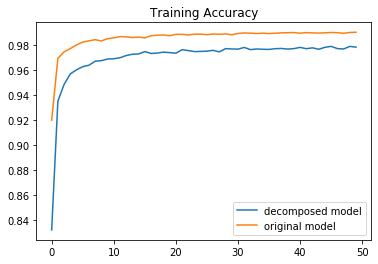

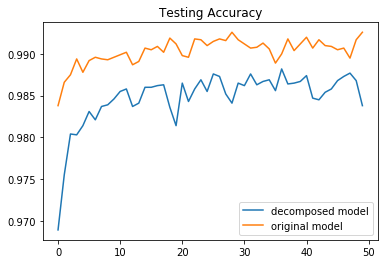

In [34]:
# plots

plt.title('Training Accuracy')
plt.plot(train_acc, label='decomposed model')
plt.plot(train_acc_full, label='original model')
plt.legend()
plt.show()

plt.title('Testing Accuracy')
plt.plot(test_acc, label='decomposed model')
plt.plot(test_acc_full, label='original model')
plt.legend()
plt.show()

In [35]:
print(best_acc, best_acc_full)

98.82 99.26
